In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab


Building a KG based on the NicheNet LigandReceptor-Signalling dataset (within their hosted weighted_networks.rds object).

The data is presented as weighted edges, so we can use the weights if using the graph directly or set a cutoff value if building a KG (unweighted).


# NicheNet KnowledgeGraph

## Constructing dKGnn

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

%%R -o dNNlr,dNNs,dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
dNNs = readRDS(url("https://zenodo.org/record/3260758/files/signaling_network.rds"))
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))

print(dNNlr.describe())
print(dNNs.describe())
print(dNNgr.describe())

dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dNNs = pd.DataFrame({
            "head":dNNs["from"],
            "relation":np.repeat("SIG", dNNs.shape[0]),
            "tail":dNNs["to"]
        })
dNNgr = pd.DataFrame({
            "head":dNNgr["from"],
            "relation":np.repeat("GR", dNNgr.shape[0]),
            "tail":dNNgr["to"]
        })

Load in pathway data from Ensembl2Reactome file. 
We will use this data to add new triples (named pathway) from REactome IDs to human gene symbols.

We're getting ensembl peptide IDs as we want to annotate human gene symbols that correspond to proteins.

from biomart import BiomartServer

#Load reactome database
dPathEnsR = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome.txt", sep="\t", header=None)
dPathEnsR = dPathEnsR.loc[dPathEnsR[5]=="Homo sapiens"][[0,1]].drop_duplicates()

#Biomart section
server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True
mart = server.datasets["hsapiens_gene_ensembl"]
response = mart.search({"attributes":["ensembl_peptide_id","hgnc_symbol"]})
#Translation
transDF = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)
transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","hgnc_symbol"]
                ).drop_duplicates() 
transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)

dPathEnsR[0] = dPathEnsR[0].map(transDict)
dPathEnsR = dPathEnsR.dropna().drop_duplicates()
dPathEnsR = pd.DataFrame({
            "head":dPathEnsR[1],
            "relation":np.repeat("pathway", dPathEnsR.shape[0]),
            "tail":dPathEnsR[0]
        })

### Make pathway metadata df

#Add in pathway metadata info: Dict with pathway name and Reactome PE IDs belonging to it
#Kepp in mind that not all of them are PTMs, some are just the protein
dPathMETA = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_Pathway.txt", sep="\t", header=None)
dPathMETA = dPathMETA.loc[
    dPathMETA[7]=="Homo sapiens"][[1,2,3,5]].drop_duplicates().rename(
        columns = {1:"PE",2:"PE_name",3:"pathway",5:"pathway_name"})
dPathMETA = dPathMETA.loc[dPathMETA["pathway"].isin(dPathEnsR["head"])].reset_index(drop=True)
dPathMETA

In [ ]:
# DEPRECATED CELL
# # print(len(dPathMETA["PE"].unique()))
# # print(len(dPathMETA["PE_name"].unique()))
# # print(len(dPathMETA["pathway"].unique()))
# # print(len(dPathMETA["pathway_name"].unique()))

# # df = dPathMETA[["pathway","pathway_name"]].drop_duplicates()

# # dPathMDdict = {}
# # for i in dPathMETA.iterrows():
# #     if i[1]["pathway"] not in dPathMDdict.keys():
# #         dPathMDdict[i[1]["pathway"]] = i[1]["pathway_name"]
# #         dPathMDdict["PEdict"] = {i[1]["PE"]:i[1]["PE_name"]}
# # print(dPathMDdict)

# # for name, group in dPathMETA.groupby(by="pathway"):
# #     print(name)
# #     print(group.to_dict("records"))

#### Save Pathway metadata

dPathMETA.to_csv(f"{data_dir}/dPathMETA.csv.tar.gz", index=False)

### Assemble triples dataset

Build final set of triples.
To make pykeen object, use from_labelled_triples() and load data columns of dKGnn as numpy and pass the metadata column (for pathways) as metadata arg.

#### Save dKGnn

dKGnn = pd.concat([dNNlr, dNNs, dNNgr, dPathEnsR]).drop_duplicates().reset_index(drop=True)
del dNNlr,dNNs,dNNgr,dPathEnsR
dKGnn

dKGnn.to_csv(f"{data_dir}/dKGnn.csv.tar.gz", index=False, header=False)

## LOAD dKGnn and metadata

Load dKGnn

In [14]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
5444497,R-HSA-6798695,pathway,SIGLEC5
5444498,R-HSA-1181150,pathway,TDGF1P3
5444499,R-HSA-1433617,pathway,TDGF1P3
5444500,R-HSA-3295583,pathway,TRPM5


Load pathway metadata

In [11]:
dPathMETA = pd.read_csv(f"{data_dir}/dPathMETA.csv.tar.gz")
dPathMETA

,PE,PE_name,pathway,pathway_name
0,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-162699,Synthesis of dolichyl-phosphate mannose
1,R-HSA-4717383,DPM1 G111Lfs*45 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
2,R-HSA-4717361,DPM1 Q210Rfs*4 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
3,R-HSA-4717370,DPM1 R92G [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
4,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-4719360,Defective DPM3 causes DPM3-CDG
...,...,...,...,...
71351,R-HSA-3209107,p14ARF mRNA [cytosol],R-HSA-8951936,RUNX3 regulates p14-ARF
71352,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-6807505,RNA polymerase II transcribes snRNA genes
71353,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-72165,mRNA Splicing - Minor Pathway
71354,R-HSA-428380,MYC mRNA [cytosol],R-HSA-428359,Insulin-like Growth Factor-2 mRNA Binding Prot...


## KGnn graph metrics

In [15]:
G = networkx.from_pandas_edgelist(dKGnn,source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
      networkx.number_of_isolates(G))
print("The graph is connected:",
     networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_146497/1248142686.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 27620 nodes and 4258252 edges, with a density of 0.011164254560457875
We have this many isolates:  0
The graph is connected: True


In [ ]:
networkx.draw(G)

# KGEmbedding

## Build the KGE

In [18]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [25]:
dKGnn.to_numpy(dtype="str")

array([['CXCL1', 'LR', 'CXCR2'],
       ['CXCL2', 'LR', 'CXCR2'],
       ['CXCL3', 'LR', 'CXCR2'],
       ...,
       ['R-HSA-1433617', 'pathway', 'TDGF1P3'],
       ['R-HSA-3295583', 'pathway', 'TRPM5'],
       ['R-HSA-9717207', 'pathway', 'TRPM5']], dtype='<U22')

In [26]:
tf = TriplesFactory.from_labeled_triples(
        dKGnn.to_numpy(dtype="str"),create_inverse_triples=False)
tf

TriplesFactory(num_entities=27620, num_relations=4, create_inverse_triples=False, num_triples=5444502)

In [27]:
import json
with open(f"{data_dir}/dKGnn_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

Compute with default model:

In [28]:
modelKGE = "KGnn_50_unstratified_stopped_transe"

using automatically assigned random_state=1715493942


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17015 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.
INFO:pykeen.evaluation.evaluator:Evaluation took 282.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.04303693077981306. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-95eb8170-6338-4543-a41f-49d8244da596.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/544k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 315.51s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=27620, num_relations=4, create_inverse_triples=False, num_triples=4355601) to file:///gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/KGEs/KGnn_50_unstratified_stopped_transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/KGEs/KGnn_50_unstratified_stopped_transe


TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(27620, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(4, 50)
    )
  )
  (weight_regularizers): ModuleList()
)
CPU times: user 1h 40min 8s, sys: 1h 25min 17s, total: 3h 5min 25s
Wall time: 35min 39s


<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

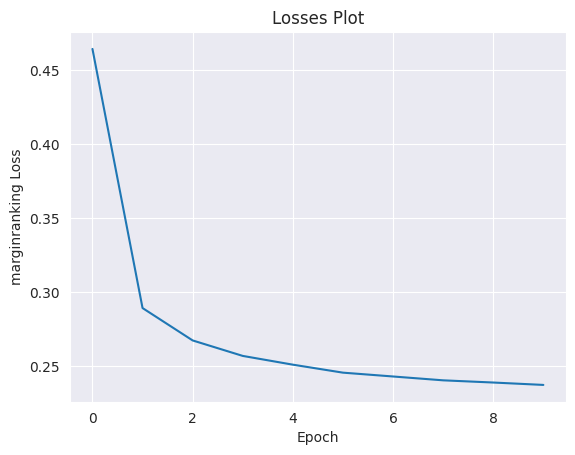

In [29]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=10,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

In [31]:
print("test")

test
